### Your name:

<pre> Derek Pyne </pre>

### Collaborators:

<pre> None </pre>


In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (15, 10)

### Classification

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember apendix B
- Study the ROC Curve, decide threshold
- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {3, 4, 6, 7, 10, 20, 50, 100} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 4, 5, 7, 10, 20, 50} 
    - Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Cross-validation with 4-folds.

- Other paramenters -> Use default

Notes:
  - Make your code modular, the second part of the assignmet you will have to repeat. 
  - Include documentation for your code 

## Obtain

First we'll read in the data and split it into a dataframe for our features and a series for our labels. We'll also keep a set for final validation.

In [3]:
df = pd.read_excel("datasets/credit/default_of_credit_card_clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)
df.drop('ID', axis=1, inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

df_labels = df['default payment next month'].copy()
df.drop('default payment next month', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, df_labels, 
                                    test_size=0.2, random_state=123)

## Explore

First we'll look at a couple of points and check for null values. In our cases there are no missing values so we can leave this step out of our pipeline.

In [5]:
X_train.head().T

,19682,11062,197,23620,26031
LIMIT_BAL,200000,120000,20000,100000,290000
SEX,2,2,2,2,2
EDUCATION,2,1,1,5,2
MARRIAGE,1,1,2,2,2
AGE,46,32,22,34,29
PAY_0,0,-1,0,0,0
PAY_2,0,-1,0,0,0
PAY_3,0,-1,0,0,0
PAY_4,0,-1,0,0,0
PAY_5,0,-1,-1,0,0


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 23 columns):
LIMIT_BAL    24000 non-null int64
SEX          24000 non-null int64
EDUCATION    24000 non-null int64
MARRIAGE     24000 non-null int64
AGE          24000 non-null int64
PAY_0        24000 non-null int64
PAY_2        24000 non-null int64
PAY_3        24000 non-null int64
PAY_4        24000 non-null int64
PAY_5        24000 non-null int64
PAY_6        24000 non-null int64
BILL_AMT1    24000 non-null int64
BILL_AMT2    24000 non-null int64
BILL_AMT3    24000 non-null int64
BILL_AMT4    24000 non-null int64
BILL_AMT5    24000 non-null int64
BILL_AMT6    24000 non-null int64
PAY_AMT1     24000 non-null int64
PAY_AMT2     24000 non-null int64
PAY_AMT3     24000 non-null int64
PAY_AMT4     24000 non-null int64
PAY_AMT5     24000 non-null int64
PAY_AMT6     24000 non-null int64
dtypes: int64(23)
memory usage: 4.4 MB


We can also look at the distribution of each feature for hints on how to process them.

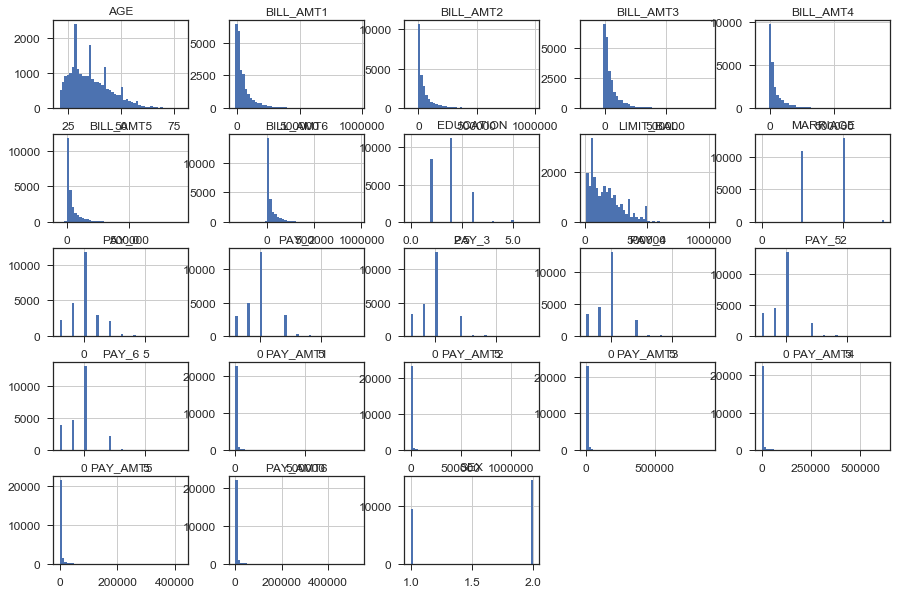

In [7]:
X_train.hist(bins=50)
plt.show()

Although all the data is in numerical form, some of these features are actually categorical. 

These features are categorical:
- Education
- Marriage
- Sex

Also, variables `PAY_0` to `PAY_6` are the repayment status over the past 6 months. These variables have a strange form in that `-1` means payment in full, while any other positive number denotes the number of months the payment was delayed. We will have to think if these variables are useful or need reshaping.

## Extract

We can now build out a pipeline by one-hot encoding our categorical features and scaling our numerical features.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# exclusion_attribs = ['PAY_0', 'PAY_1', 'PAY_2', 'PAY_3', 
#                      'PAY_4', 'PAY_5', 'PAY_6']
exclusion_attribs = []
cat_attribs = ['EDUCATION', 'MARRIAGE', 'SEX']
num_attribs = [c for c in df.columns 
               if c not in cat_attribs and c not in exclusion_attribs]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder())
    ])

In [11]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
X_train_prepared = full_pipeline.fit_transform(X_train)

/Users/helpfulmacpro2/anaconda3/envs/helpful-analytics/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Model

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators' : [3, 4, 6, 7, 10, 20, 50, 100]}
grid_search_rfc = GridSearchCV(rf, param_grid, cv=4, scoring='accuracy')
grid_search_rfc.fit(X_train_prepared, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [13]:
cvres = grid_search_rfc.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('Params: %s, Accuracy: %.3f' % (params, mean_score))

Params: {'n_estimators': 3}, Accuracy: 0.767
Params: {'n_estimators': 4}, Accuracy: 0.790
Params: {'n_estimators': 6}, Accuracy: 0.797
Params: {'n_estimators': 7}, Accuracy: 0.796
Params: {'n_estimators': 10}, Accuracy: 0.805
Params: {'n_estimators': 20}, Accuracy: 0.810
Params: {'n_estimators': 50}, Accuracy: 0.814
Params: {'n_estimators': 100}, Accuracy: 0.815


In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 4, 5, 7, 10, 20, 50]}
grid_search_knn = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy')
grid_search_knn.fit(X_train_prepared, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5, 7, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [16]:
cvres = grid_search_knn.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('Params: %s, Accuracy: %.3f' % (params, mean_score))

Params: {'n_neighbors': 3}, Accuracy: 0.774
Params: {'n_neighbors': 4}, Accuracy: 0.797
Params: {'n_neighbors': 5}, Accuracy: 0.792
Params: {'n_neighbors': 7}, Accuracy: 0.800
Params: {'n_neighbors': 10}, Accuracy: 0.806
Params: {'n_neighbors': 20}, Accuracy: 0.811
Params: {'n_neighbors': 50}, Accuracy: 0.810


## Interpret

We will now take our top model with the Random Forest Classifier and evaluate it on our test set.

In [17]:
X_test_prepared = full_pipeline.transform(X_test)
y_test_prob = grid_search_rfc.predict_proba(X_test_prepared)[:,1]

/Users/helpfulmacpro2/anaconda3/envs/helpful-analytics/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_test_prob, 
                                         pos_label=1)

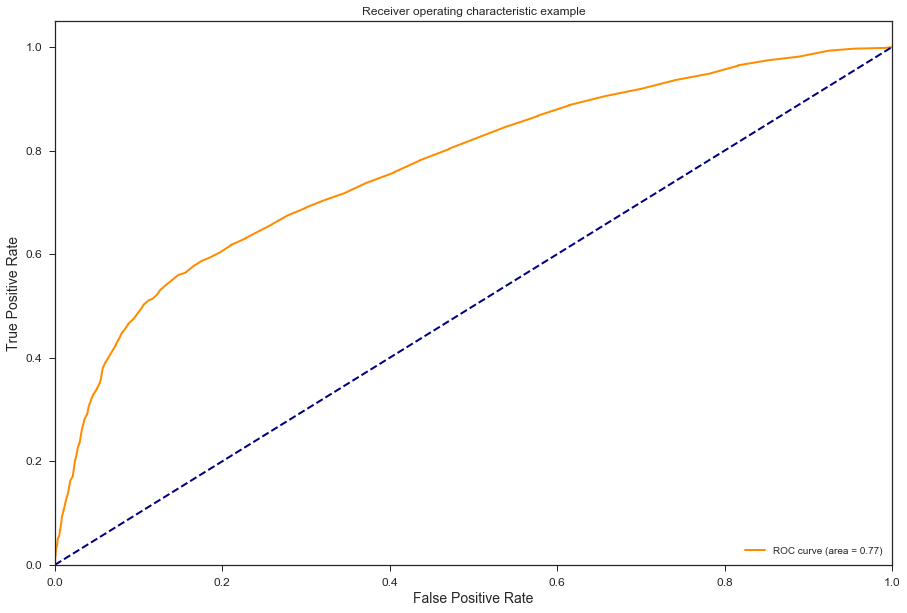

In [19]:
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

We choose a threshold based on a true positive rate of 0.6.

In [20]:
thresholds[np.argmax(tpr > .6)]

0.28000000000000003

#### Conclusions?

Explain your results and choices

- Choosing between 4 and 5 fold cross validation had no affect on accuracy but a significant affect on compute time so 4 fold validation was used. This is likely because the dataset is large enough that for our particular models they are able to extract all the variance in the dataset that they can use with 75% of the training set as compared to 80%. In general, if the dataset was smaller (compared to the variance in the data) or we choose a model with higher capability this might not be the case.
- Some of the repayment variables seemed a little strange so an attempt was made to remove them. The variables `PAY_0` through `PAY_6` were removed but this led to a 3% decrease in accuracy so they were left in the dataset.
- The business needs are needed to properly choose a threshold. The tradeoff here, for the case of credit default, is lost investment if the customer defaults on their payment and the model was not able to flag them, and a poor customer experience if the model falsely flags the customer. We will choose a value in the middle here of 0.28 which is based on a true positive rate of 0.6.

Q2. (Optional) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion. 

To test this out we will use an example for SK-Learn for digit recognition and add our image shifter to the dataset.

We will wrap the example in a function to make it easier to work with.

In [41]:
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

X = digits.images
y = digits.target

In [44]:
# mnist data is taking two long to train so going to use the toy digits dataset for now

# mnist = datasets.fetch_mldata('MNIST original')
# X = mnist['data']
# y = mnist['target']
# np.random.shuffle(X)
# np.random.shuffle(y)
# X = X[:3000, :]
# y = y[:3000]

In [45]:
def digit_recognition(X, y):
    # Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
    # License: BSD 3 clause
    
    # To apply a classifier on this data, we need to flatten the image, to
    # turn the data in a (samples, feature) matrix:
    n_samples = len(X)
    
    X_copy = X.copy()
    X_copy = X_copy.reshape((n_samples, -1))

    # Create a classifier: a support vector classifier
    classifier = svm.SVC(gamma=0.001)

    # We learn the digits on the first half of the digits
    
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, 
                                    test_size=0.2, random_state=123)
    classifier.fit(X_train, y_train)

    # Now predict the value of the digit on the second half:
    expected = y_test
    predicted = classifier.predict(X_test)

    print('Accuracy: %s' % metrics.accuracy_score(expected, predicted))

In [46]:
digit_recognition(X, y)

Accuracy: 0.991666666667


Now we can make a function that will shift an image by a pixel in each direction.

In [47]:
def shift_image(image, direction='north'):
    shifted = np.zeros(image.shape)
    if direction == 'north':
        shifted[:-1, :] = image[1:, :]
    elif direction == 'south':
        shifted[1:, :] = image[:-1, :]
    elif direction == 'east':
        shifted[:, 1:] = image[:, :-1]
    elif direction == 'west':
        shifted[:, :-1] = image[:, 1:]
    else:
        print('Provided invalid direction of %s. Not shifting image.' % direction)
        shifted = image
    return shifted

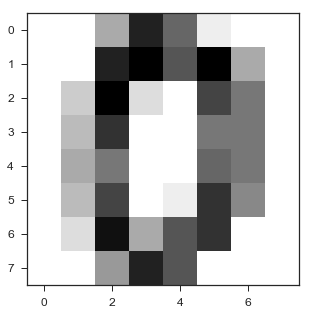

In [49]:
plt.figure(figsize=(5,5))
plt.imshow(X[0], 
           cmap=plt.cm.gray_r, interpolation='nearest')

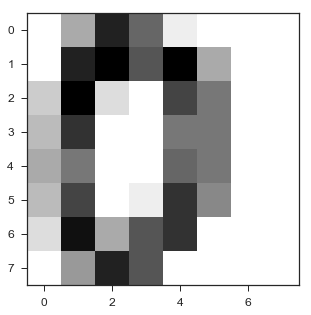

In [50]:
plt.figure(figsize=(5,5))
plt.imshow(shift_image(X[0], direction='west'), 
           cmap=plt.cm.gray_r, interpolation='nearest')

In [51]:
X_shifted = []
y_shifted = []
for X, y in zip(X, y):
    for direction in ['north', 'south', 'west', 'east']:
        X_shifted.append(shift_image(X, direction))
        y_shifted.append(y)


In [52]:
digit_recognition(X + X_shifted, y + y_shifted)

Accuracy: 0.989568845619


The mnist data was taking too long to train so the toy digits sklearn dataset was used for now. With this dataset, the model without shifting was already incredibly accurate, so although shifting slightly lowered the accuracy it is hard to read into it.

Also, the current setup is putting the shifted data into the test set as well. The correct setup should probably be to do cross-validation with the training set with the added shifted images and then test the quality of the model on a test set that does not have shifted images. But because of the mnist runtime on my laptop this will have to wait for now :)